# Chapter 16: Logistic Regression

In this chapter we will attempt to find decsion boundaries in order to make discrete classification decsions.

### Imports

In [1]:
# Import libraries
import math, my_utils, sys, random, pylab
%matplotlib inline
import matplotlib.pyplot as plt
from functools import reduce, partial
from collections import Counter
import numpy as np

# Import needed notebooks
import NotebookLoader
sys.meta_path.append(NotebookLoader.NotebookFinder())
import Chapter4 as Ch4
import Chapter8 as Ch8
import Chapter11 as Ch11
import Chapter13 as Ch13

# set fig size 
pylab.rcParams['figure.figsize'] = (15.0, 12.0)

importing Jupyter notebook from Chapter4.ipynb
importing Jupyter notebook from Chapter8.ipynb
importing Jupyter notebook from Chapter11.ipynb
importing Jupyter notebook from Chapter13.ipynb


### Logistic Function

We will use fit a logistic function to our model whose output is the probabilty of being in a certain class

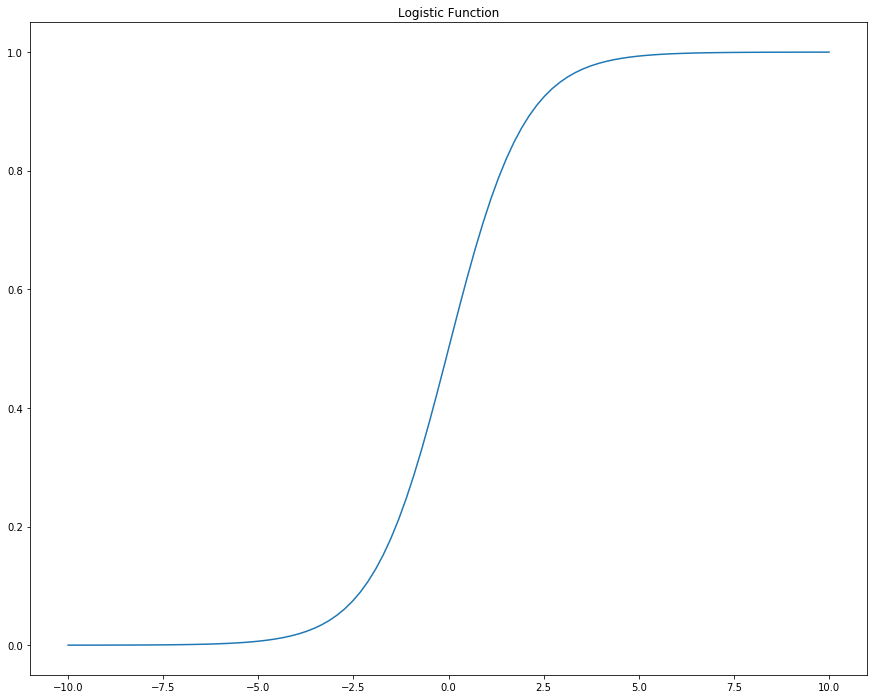

In [2]:
def logistic(x):
    """Apply the logistic function to x"""
    return 1 / (1 + math.exp(-x))

def logistic_prime(x):
    """Apply the derivative of the logistic function to x"""
    return logistic(x) * (1 - logistic(x))

if __name__ == "__main__":
    n = 100
    x = my_utils.linspace(-10, 10, 100)
    y = [logistic(x_i) for x_i in x]
    plt.plot(x,y)
    plt.title("Logistic Function")
    plt.draw()

### Fitting the Model
We will use these functions to fit the model:

$y_i = f(x_i \beta) * \varepsilon_i$

where $f$ is the `logistic` function defined above.

Here we will use gradient descent to maximize the likelihood of the data given our $\beta$, meaning that we need to calculate the likelihood function and its gradient.

Given some $\beta$, $y_i$ should equal 1 with probability $f(x_i \beta)$ and 0 with probability $1 - f(x_i\beta)$.

The pdf for $y_i$ can be written as:

$p(y_i|\beta) = f(x_i\beta)^{y_i}(1-f(x_i \beta))^{1-y_i}$

In practice it is easier to maximize the log likelihood given below:

$\log(L(\beta | x_i, y_i) = y_i \log f(x_i \beta) + (1-y_i)\log (1 - f(x_i \beta))$

Since $\log$ is monotonicly increasing, any $\beta$ which maximizes the log likelihood also maximizes the likelihood.

### Define Log Likelihood

In [3]:
def logistic_log_likelihood_i(x_i, y_i, beta):
    if y_i == 1:
        return math.log(logistic(Ch4.dot(x_i, beta)))
    else:
        return math.log(1 - logistic(Ch4.dot(x_i, beta)))

def logistic_log_likelihood(x, y, beta):
    return sum(logistic_log_likelihood_i(x_i, y_i, beta) for x_i, y_i in zip(x, y))

### Define Gradient

In [4]:
def logistic_log_partial_ij(x_i, y_i, beta, j):
    """Here i is the index of the data point and j is the index of the deriv"""
    return (y_i - logistic(Ch4.dot(x_i, beta))) * x_i[j]

def logistic_log_gradient_i(x_i, y_i, beta):
    """the gradient of the log likelihood corresponding to the ith data point"""
    return [logistic_log_partial_ij(x_i, y_i, beta, j)
            for j,_ in enumerate(beta)]

def logistic_log_gradient(x, y, beta):
    return reduce(Ch4.vector_add,
                  [logistic_log_likelihood_i(x_i, y_i, beta)
                   for x_i, y_i in zip(x,y)])

### Generate some dummy data

We will generate data such that the positive example lie in above the line $y = \frac{1}{3} x$ with eror term $\varepsilon \sim U(0,0.5)$, all else are negative.

In [5]:
def rand_dat_pt(beta):
    x1 = random.uniform(-1,1)
    x2 = random.uniform(-1,1)
    c = 1 if (x1 * beta[0] + x2 * beta[1] + random.random() / 2> 0) else 0
    return ((x1, x2), c)

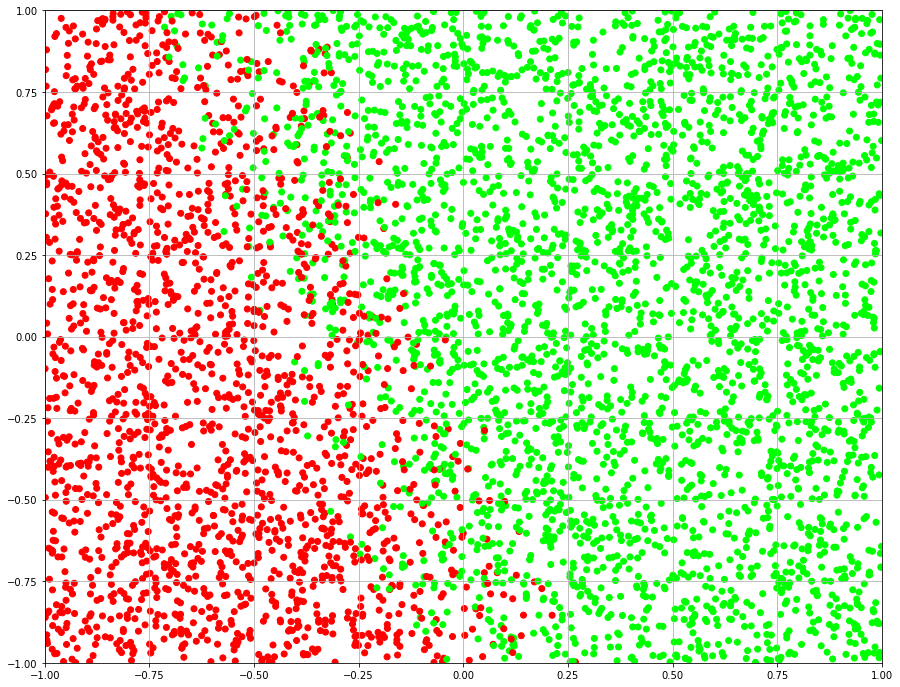

In [6]:
if __name__ == "__main__":
    t_beta = [1,.3]
    data = [rand_dat_pt(t_beta) for _ in range(5000)]
    x, y = zip(*data)

    # rgba values for red and green (negative and positive)
    red = [1, 0, 0, 1]
    green = [0, 1, 0, 1]

    # apply colors according to pos/neg
    colors = [green if y_i == 1 else red for y_i in y]

    # plot the data colored by label

    plt.scatter(*zip(*x), c=colors)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.grid(True)
    plt.draw()

### Train Model

In [7]:
if __name__ == "__main__":
    x_train, x_test, y_train, y_test = Ch11.train_test_split(x, y, 0.33)

    # we want to maximize log likelihood on training data
    fn = partial(logistic_log_likelihood, x_train, y_train)
    gradient_fn = partial(logistic_log_gradient, x_train, y_train)

    # random starting point
    beta_0 = [random.random() for _ in range(2)]

    # maximize using gradient descent
    beta_hat = Ch8.maximize_stochastic(logistic_log_likelihood_i, 
                                       logistic_log_gradient_i,
                                       x_train, y_train, beta_0, alpha_0=1)
    
    print("Solved beta is {0}".format(beta_hat))

Calling maximize
Solved beta is [6.083430006637906, 1.9261225635657142]


In [8]:
# make ROC values given p threshold (returns (false positive rate, true posiitve rate pair))
def calc_fp_tp_rates(p, truth_pred):
    # assume 0.5 probability cutoff, count combinations of (is_spam, pred_is_spam)
    counts = Counter((y_i, y_i_hat > p) 
                     for y_i, y_i_hat in truth_pred)
    
    # get counts 
    TN = counts[(False, False)]
    TP = counts[(True, True)]
    FN = counts[(True, False)]
    FP = counts[(False, True)]
    
    # false positive rate is FP/(FP + TN)
    fpr = FP/(FP + TN)
    
    # true positive rate is TP/(TP + FN)
    tpr = TP/(TP + FN)
    
    return (fpr, tpr)

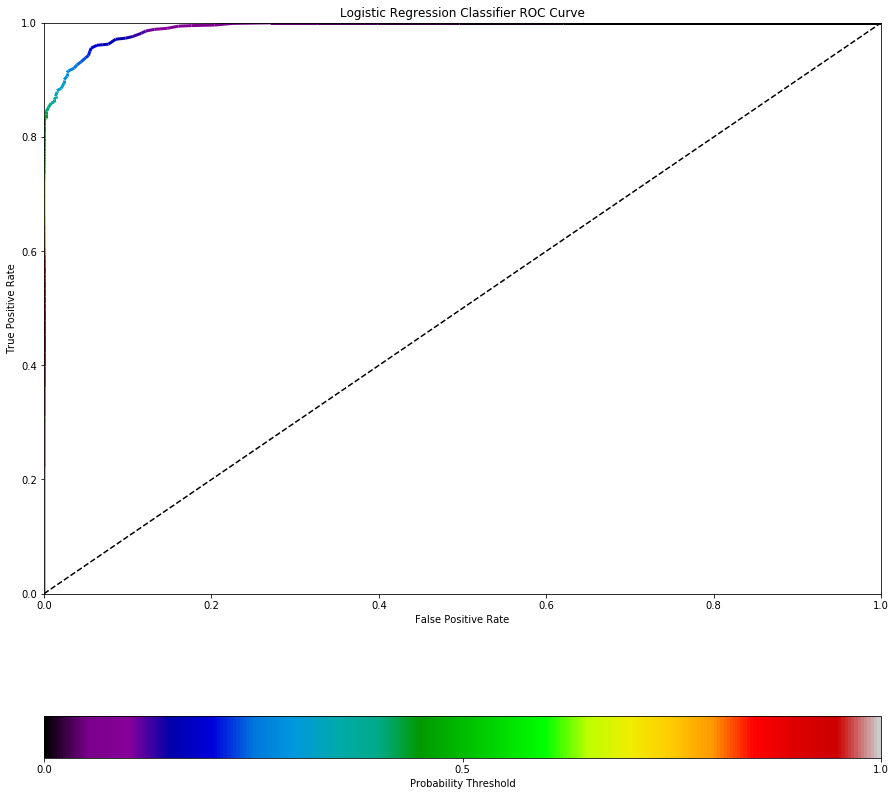

In [9]:
if __name__ == "__main__":
    from matplotlib.collections import LineCollection
    from matplotlib.colors import ListedColormap, BoundaryNorm
    
    # Set plot size
    pylab.rcParams['figure.figsize'] = (15.0, 15.0)
    
    # zip together truth values and predicted logistic output
    truth_pred = [(y_i, logistic(Ch4.dot(beta_hat, x_i))) 
                  for x_i, y_i in zip(x_test, y_test)]
    
    # setup thresholds from 0 to 1
    thresholds = my_utils.linspace(0, 1, 100)
    
    # calculate (fpr, tpr) pairs for each threshold
    roc_vals = [calc_fp_tp_rates(p_i, truth_pred) for p_i in thresholds]
    
    # unzip into x (FP) and y(TP) arrays
    x, y = zip(*roc_vals)
    
    # Make LineCollection (allows continuous line coloring according to colormap)
    points = np.array([np.array(x), np.array(y)]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=plt.get_cmap('nipy_spectral'), norm=plt.Normalize(0, 1))
    interval = np.array(thresholds)
    lc.set_array(interval)
    lc.set_linewidth(3)
    
    # Make figure and set params
    fig2 = plt.figure()
    plt.gca().add_collection(lc)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Logistic Regression Classifier ROC Curve")
    cbar = fig2.colorbar(lc, ticks=[0, 0.5, 1], orientation='horizontal',
                         label="Probability Threshold")
    
    # Add reference identity line (represents random guess threshold)
    plt.plot([0,1], 'k--')
    
    # Show the figure
    plt.show()

In [10]:
if __name__ == "__main__":
    # need to reverse roc_vals, x is descending
    roc_vals.reverse()
    auc = Ch13.trapezoidal_rule_AUC(roc_vals)
    print("The Area Under the ROC Curve is {0:.3f}".format(auc))

The Area Under the ROC Curve is 0.992


Thus our ROC AUC is close to 1 (maximum) so our model performs pretty well.